In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join('../..', 'src')))
sys.setrecursionlimit(20500)
import pandas as pd
import spacy

import matplotlib.pyplot as plt
import clean_dataset as clean
import make_dataset as mk
import vectorize_embed as em
import tools as tools
import models as m

import pickle
import numpy as np

'''features'''
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize

'''Classifiers'''
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.pipeline import Pipeline

'''Metrics/Evaluation'''
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from scipy import interp
from itertools import cycle
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline

import joblib
import seaborn as sns

[nltk_data] Downloading package stopwords to C:\Users\Jonas
[nltk_data]     Nothnagel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Jonas
[nltk_data]     Nothnagel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [2]:
'''import data'''

df = pd.read_excel(os.path.abspath(os.path.join('../..', 'data/processed/encoded_labels'))+'/oceans_water_full.xlsx')  
'''lowercase data and str type data'''
df['all_text_clean_spacy'] = df['all_text_clean_spacy'].astype(str).apply(clean.basic)
df['all_text_clean'] = df['all_text_clean'].astype(str)

In [3]:
# '''remove small data points'''
# df_trunc = mk.truncate(df, 300, save=True, printing =False)

# '''remove french entries'''
# df_all_clean = clean.detect_lang(df_trunc, "fr", printing =False)

# '''remove spanish entries'''
# df_all_clean = clean.detect_lang(df_trunc, "es", printing =False)

In [4]:
print(df.shape)
print(df.columns)

(603, 11)
Index(['Unnamed: 0', 'PIMS_ID', 'all_text_clean', 'all_text_clean_spacy',
       'oceans_and_water_programme', 'small_island_dev_states_program_sids',
       'climate_resilient_access_to_water_supply_sanitation',
       'climate_resilient_integrated_water_resource_coastal_area_management',
       'cross_cutting_governance_and_learning',
       'protection_of_transboundary_surface_groundwater_resources_in_a_changing_climate',
       'sustainable_management_of_oceans_in_a_changing_climate'],
      dtype='object')


<AxesSubplot:>

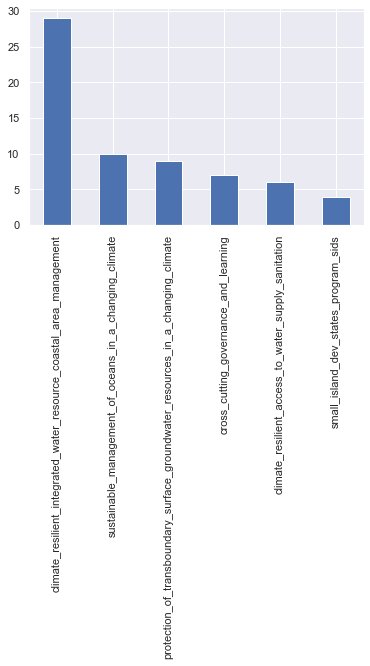

In [5]:
df[['small_island_dev_states_program_sids',
       'climate_resilient_access_to_water_supply_sanitation',
       'climate_resilient_integrated_water_resource_coastal_area_management',
       'cross_cutting_governance_and_learning',
       'protection_of_transboundary_surface_groundwater_resources_in_a_changing_climate',
       'sustainable_management_of_oceans_in_a_changing_climate']].sum(axis=0).sort_values(ascending = False).plot.bar()

In [6]:
categories = ['small_island_dev_states_program_sids',
       'climate_resilient_access_to_water_supply_sanitation',
       'climate_resilient_integrated_water_resource_coastal_area_management',
       'cross_cutting_governance_and_learning',
       'protection_of_transboundary_surface_groundwater_resources_in_a_changing_climate',
       'sustainable_management_of_oceans_in_a_changing_climate']

remove = []

## Run and Save best baseline models:

In [9]:
# iterate over categories and save best models:
    #Creating a dict of the models
model_dict = {
              'Logistic Regression balanced' : LogisticRegression(random_state = 3, class_weight = "balanced"),
              'Logistic Regression' : LogisticRegression(random_state = 3),
              'Stochastic Gradient Descent' : SGDClassifier(random_state=3, loss='log'),
              'SGD_balanced' : SGDClassifier(random_state=3, loss='log',class_weight = "balanced" ),
              'Random Forest': RandomForestClassifier(random_state=3),
              'Decsision Tree': DecisionTreeClassifier(random_state=3),
              'AdaBoost': AdaBoostClassifier(random_state=3),
              'Gaussian Naive Bayes': GaussianNB(),
              'K Nearest Neighbor': KNeighborsClassifier()}
    
for category in categories: 
    
    print('processing:', category)
    print('_____')
    #Creating the features (tf-idf weights) for the processed text
    texts = df_all_clean['all_text_clean'].astype('str')

    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                       min_df = 2, 
                                       max_df = .95)
    X = tfidf_vectorizer.fit_transform(texts)     
    y = df_all_clean[category].values
    
    if len(category) > 50:
         shorter = category[0:50]
         #save vectorizer:
         filename = '../../models/tf_idf/technical_team/'+shorter+'_'+'vectorizer.sav'
         joblib.dump(tfidf_vectorizer, filename)    
        
    else:
        #save vectorizer:
        filename = '../../models/tf_idf/technical_team/'+category+'_'+'vectorizer.sav'
        joblib.dump(tfidf_vectorizer, filename)    
        
    #Dimenionality reduction. Only using the 100 best features er category
    lsa = TruncatedSVD(n_components=100, 
                       n_iter=10, 
                       random_state=3)
    X = lsa.fit_transform(X)

    if len(category) > 50:
        print('long')
        shorter = category[0:50]
        #save lsa model:
        filename = '../../models/tf_idf/technical_team/'+shorter+'_'+'lsa.sav'
        joblib.dump(lsa, filename)
    else:
        #save vectorizer:
        filename = '../../models/tf_idf/technical_team/'+category+'_'+'lsa.sav'
        joblib.dump(lsa, filename)  
    
    #Train test split with stratified sampling for evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size = .3, 
                                                        shuffle = True, 
                                                        stratify = y, 
                                                        random_state = 3)
    
    m.model_score_df(model_dict, category, 'technical_team', X_train, X_test, y_train, y_test)

processing: small_island_dev_states_program_sids
_____
small_island_dev_states_program_sids
processing: climate_resilient_access_to_water_supply_sanitation
_____
long
climate_resilient_access_to_water_supply_sanitatio
processing: climate_resilient_integrated_water_resource_coastal_area_management
_____
long
climate_resilient_integrated_water_resource_coasta
processing: cross_cutting_governance_and_learning
_____
cross_cutting_governance_and_learning
processing: protection_of_transboundary_surface_groundwater_resources_in_a_changing_climate
_____
long
protection_of_transboundary_surface_groundwater_re
processing: sustainable_management_of_oceans_in_a_changing_climate
_____
long
sustainable_management_of_oceans_in_a_changing_cli


## Classification trials

In [9]:
#Creating the features (tf-idf weights) for the processed text
texts = df_all_clean['all_text_clean'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts)
   
    
y = df_all_clean['energy_efficiency'].values

#Dimenionality reduction. Only using the 100 best features er category

lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)


In [10]:
#Preliminary model evaluation using default parameters

#Creating a dict of the models
model_dict = {'Dummy' : DummyClassifier(random_state=3),
              'Logistic Regression balanced' : LogisticRegression(random_state = 3, class_weight = "balanced"),
              'Logistic Regression' : LogisticRegression(random_state = 3),
              'Stochastic Gradient Descent' : SGDClassifier(random_state=3, loss='log'),
              'Stochastic Gradient Descent balanceed' : SGDClassifier(random_state=3, loss='log',class_weight = "balanced" ),
              'Random Forest': RandomForestClassifier(random_state=3),
              'Decsision Tree': DecisionTreeClassifier(random_state=3),
              'AdaBoost': AdaBoostClassifier(random_state=3),
              'Gaussian Naive Bayes': GaussianNB(),
              'K Nearest Neighbor': KNeighborsClassifier()}

#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)


#Function to get the scores for each model in a df
def model_score_df(model_dict):   
    
    models, model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], [], []
    
    for k,v in model_dict.items():   

        
        v.fit(X_train, y_train)
        
        model_name.append(k)
        models.append(v)
        
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
        
    results = dict(zip(model_name, models))
    return model_comparison_df, results

model_df, results = model_score_df(model_dict)
model_df

C:\Users\Jonas\Anaconda3\envs\nce_1\lib\site-packages\sklearn\dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "


,model_name,accuracy_score,precision_score,recall_score,f1_score
3,Stochastic Gradient Descent,0.952941,0.918019,0.843333,0.875731
4,Stochastic Gradient Descent balanceed,0.923529,0.804325,0.891667,0.839518
9,K Nearest Neighbor,0.929412,0.83,0.83,0.83
5,Random Forest,0.941176,0.929852,0.771667,0.827516
1,Logistic Regression balanced,0.911765,0.783128,0.906667,0.82699
7,AdaBoost,0.923529,0.80908,0.848333,0.826952
6,Decsision Tree,0.917647,0.801667,0.801667,0.801667
8,Gaussian Naive Bayes,0.894118,0.752381,0.853333,0.788966
2,Logistic Regression,0.894118,0.946429,0.55,0.562607
0,Dummy,0.817647,0.53268,0.528333,0.529926


## With weights

In [ ]:
def binary_log_classifier(dataframe, category, add_weights =True):
    X_train, X_test, y_train, y_test = train_test_split(dataframe['all_text_clean_spacy'],
                                                        dataframe[category].values,
                                                        test_size = .3,
                                                        random_state = 1,
                                                        shuffle = True)
    print('training size:', len(X_train))
    print('test size:', len(X_test))
    print('distribution of tagged projects:', dataframe[category].value_counts())
    #if weighted == True:
        #class_weights = tools.get_class_weights(y_train)
        #print(class_weights)
    #else: 
        #class_weights = None
        
    vectorizer = TfidfVectorizer(ngram_range = (1,2),min_df = 0.01, max_df = 0.95)
    vect = vectorizer.fit(X_train)
    X_train = vect.transform(X_train)
    X_test = vect.transform(X_test)        
    
    "feature reduction"
    #lsa = TruncatedSVD(n_components=100, 
                   #n_iter=10, 
                   #random_state=3)

    #X_train = lsa.fit_transform(X_train)
    #X_test = lsa.fit_transform(X_test)    

    '''add additional feature weight'''
    if add_weights == True:
        weight = 5
        position = vect.vocabulary_['persistent organic']
        X_train[:, position] *= weight
        X_test[:, position] *= weight
        position = vect.vocabulary_['pops']
        X_train[:, position] *= weight
        X_test[:, position] *= weight
        position = vect.vocabulary_['upops']
        X_train[:, position] *= weight
        X_test[:, position] *= weight
        position = vect.vocabulary_['pcbs']
        X_train[:, position] *= weight
        X_test[:, position] *= weight
        position = vect.vocabulary_['pcb']
        X_train[:, position] *= weight
        X_test[:, position] *= weight
    else:
        pass
    # set pipeline
    pipe = Pipeline([('classifier' , LogisticRegression())])

    # Create param grid.
    param_grid = [
        {'classifier' : [LogisticRegression(class_weight = "balanced")],
         'classifier__penalty' : ['l1', 'l2'],
        'classifier__C' : np.logspace(-4, 4, 20),
        'classifier__solver' : ['liblinear ','lbfgs']}
    ]

    # Create grid search object
    clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1, scoring = 'f1')

    # Fit on data
    best_clf = clf.fit(X_train, y_train)
    print('')
    print('Training accuracy:', best_clf.score(X_train, y_train).round(3))
    print('Test accuracy:', best_clf.score(X_test, y_test).round(3))
    y_hat = best_clf.predict(X_test)
    print('f1_score', f1_score(y_test, y_hat))

    from sklearn.metrics import classification_report
    print(classification_report(y_test, y_hat))    
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
    specificity = tn / (tn+fp)
    print('specificity is:', specificity)

    return best_clf, vectorizer, y_train

In [ ]:
best_clf, vectorizer, y_train = binary_log_classifier(df_all_clean, 'persistent_organic_pollutants', add_weights = True)

# precision 0.33 on class 1: 33% of all items predicted as 1 are truly 1.
# recall 0.6 on class 1: 60% of all true 1 are predicted as 1. 

## print top regressors:

train size: 395
test size: 170

Training accuracy: 0.995
Test accuracy: 0.994
f1 score: 0.6666666666666666


label_1    sap
dtype: object

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       169
           1       0.50      1.00      0.67         1

    accuracy                           0.99       170
   macro avg       0.75      1.00      0.83       170
weighted avg       1.00      0.99      1.00       170



<AxesSubplot:xlabel='score', ylabel='features'>

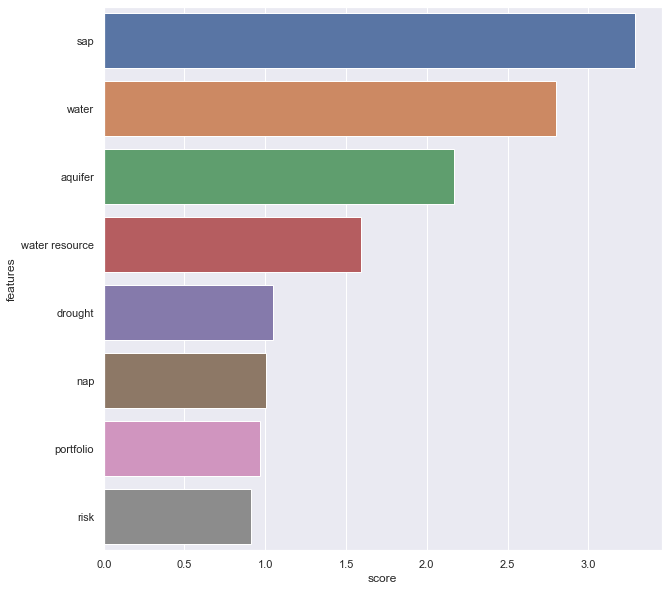

In [10]:
df_regressors = pd.DataFrame(columns = ["label", "features", "score"])


X_train, X_test, y_train, y_test = train_test_split(df_all_clean['all_text_clean_spacy'],
                                                    df_all_clean['climate_resilient_access_to_water_supply_sanitation'].values,
                                                    test_size = .3,
                                                    random_state = 1,
                                                    shuffle = True)
print('train size:', len(X_train))
print('test size:', len(X_test))

assert len(set(y_train)) == len(set(y_test)), "Unequal splits with some labels missing"

'''extract features using tfidf vecorization:'''
vectorizer = TfidfVectorizer(ngram_range = (1,2),min_df = 0.01, max_df = 0.95)


vect = vectorizer.fit(X_train)
X_train = vect.transform(X_train)
X_test = vect.transform(X_test)

#add additional feature weight

# weight = 10

# position = vect.vocabulary_['pops']
# X_train[:, position] *= weight
# X_test[:, position] *= weight
# position = vect.vocabulary_['upops']
# X_train[:, position] *= weight
# X_test[:, position] *= weight
# position = vect.vocabulary_['pcbs']
# X_train[:, position] *= weight
# X_test[:, position] *= weight


clf = LogisticRegression(penalty='l2', solver = 'lbfgs', class_weight= 'balanced').fit(X_train, y_train)
print('')
print('Training accuracy:', clf.score(X_train, y_train).round(3))
print('Test accuracy:', clf.score(X_test, y_test).round(3))
y_hat = clf.predict(X_test)
print('f1 score:', f1_score(y_test, y_hat))
#top regressors 
#return top  regressors and convert to dataframe for visualisation:
df_lambda = tools.get_topwords(clf, vectorizer, n = 8, n_models = 1, show_idxmax = True)
keywords = df_lambda.Keywords.iloc[0]

for key in keywords:

    df_regressors = df_regressors.append({'label': 'persistent_organic_pollutants', "features":key}, ignore_index=True)
    df_regressors['features'] = df_regressors['features'].astype(str)
    df_regressors['features'] = df_regressors['features'].str.replace('(','')
    df_regressors['features'] = df_regressors['features'].str.replace(')','')
    df_regressors['features'] = df_regressors['features'].str.replace("'",'')               

from sklearn.metrics import classification_report
print(classification_report(y_test, y_hat))

df_regressors[['features','score']] = df_regressors['features'].str.split(',',expand=True)
df_regressors['score'] = df_regressors['score'].astype(float)    
plt.figure(figsize=(10,10))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = df_regressors)